## **Methodology & Technical Framework**

**Project Scope:** The goal of this project is to build an end-to-end machine learning pipeline to predict credit default risk. By leveraging a modern data science stack, we aim to process large-scale financial data, handle severe class imbalance, and deliver a model that balances high predictive accuracy (AUC/Recall) with regulatory interpretability.

**Technical Architecture:** The workflow relies on four core pillars, each supported by specialized libraries:

- **High-Performance Data Engineering:** We utilize Polars and DuckDB for their superior speed and memory efficiency compared to traditional tools. These engines allow us to perform complex aggregations and window functions on large datasets rapidly, while Pandas and NumPy handle granular array manipulations.

- **Advanced Gradient Boosting:** The modeling phase centers on LightGBM and XGBoost. These state-of-the-art algorithms are chosen for their ability to handle large tabular datasets, manage missing values natively, and optimize for class imbalance using weighted loss functions.

- **Rigorous Validation Strategy:** We employ Scikit-Learn to implement Stratified K-Fold Cross-Validation. This ensures that our validation sets strictly mirror the real-world imbalance (8% default rate), preventing data leakage and guaranteeing that our metrics (AUC, Recall) are statistically robust.

- **Model Explainability:** To bridge the gap between "Black Box" performance and "White Box" transparency, we integrate SHAP (SHapley Additive exPlanations). This allows us to deconstruct complex model predictions into human-readable insights, satisfying the explainability requirements of the banking sector.

In [23]:
#| echo: true
#| code-fold: false
import polars as pl
import pandas as pd
import numpy as np
import duckdb
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import polars.selectors as cs
import plotly.graph_objects as go
import lightgbm as lgb
import shap
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import polars as pl
import pandas as pd
import numpy as np
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix)

import warnings
warnings.filterwarnings("ignore")
pio.renderers.default = "notebook"
# Reset options (optional, to avoid messing up future prints)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

## **Read the data**

Let's load the final pre-processed Parquet dataset, which encapsulates all prior cleaning steps, engineered features, and Weight of Evidence (WoE) encoded variables ready for modeling

In [24]:
#| echo:true
#| code-fold:false

file_path = "C:/Users/asado/Desktop/Home Credit Dataset/Machine Learning/home_credit_final_cleaned.parquet"
df = pl.read_parquet(file_path)

# Quick check
print(f"Data Loaded. Shape: {df.shape}")
df.head()

Data Loaded. Shape: (307511, 146)


SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,…,pos_term_variance,ins_late_payment_count,ins_avg_dpd,ins_max_dpd,ins_avg_dbd,ins_max_dbd,ins_underpayment_count,ins_payment_ratio,ins_total_missed_balance,ins_version_change_count,ins_recent_late_count_1y,bureau_total_loans_count,bureau_active_loans_count,bureau_closed_loans_count,bureau_credit_card_count,bureau_mortgage_count,bureau_car_loan_count,bureau_total_active_debt,bureau_total_active_limit,bureau_total_overdue_amount,bureau_max_overdue_ever,bureau_utilization_rate,bureau_days_since_last_loan,bureau_days_until_next_end,bureau_max_delinquency_level_ever,bureau_total_late_months_history,ratio_credit_to_income,ratio_annuity_to_income,ratio_annuity_to_credit,ratio_total_debt_to_income,ratio_total_credit_limit_to_income,feature_disposable_income,ratio_employed_to_age,ratio_income_to_age,ORGANIZATION_TYPE_WoE,OCCUPATION_TYPE_WoE,most_freq_seller_industry_prev_WoE
i64,i64,u32,u32,u32,u32,i64,f64,f64,f64,f64,u32,u32,u32,u32,u32,f64,i64,i64,f64,i64,f64,i64,i64,i64,i64,i64,i64,f64,i64,i64,u32,i64,i64,i64,i64,i64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
384405,0,0,0,0,0,0,126000.0,780363.0,31077.0,697500.0,0,0,0,0,0,0.032561,-18334,-2918,-1345.0,-1804,15.0,1,1,0,1,0,0,2.0,1,1,0,17,0,0,0,0,…,2.260526,0.0,0.0,0.0,38.315789,71.0,0.0,1.0,0.0,2,0.0,1,1.0,0.0,0.0,0.0,0.0,1.275228e6,1.35e6,0.0,null,0.944613,-308,null,null,0.0,6.193357,0.246643,0.039824,16.314214,16.907643,94923.0,0.159158,6.872477,0.156938,0.290375,-0.102228
384407,0,0,0,1,0,0,112500.0,331834.5,20182.5,252000.0,1,0,0,1,0,0.005084,-11368,-2860,-3625.0,-3506,null,1,1,0,1,0,0,2.0,2,2,0,10,1,1,0,1,…,4.69697,0.0,0.0,0.0,13.7,39.0,0.0,1.0,0.0,2,0.0,3,3.0,0.0,2.0,0.0,0.0,173700.0,387000.0,0.0,null,0.448837,-60,1510.0,0,0.0,2.94964,0.1794,0.060821,4.49364,6.38964,92317.5,0.251583,9.8962,-0.303195,0.281369,0.119861
384408,0,0,0,1,0,0,202500.0,545040.0,20677.5,450000.0,1,0,0,0,0,0.010276,-18286,-2789,-10980.0,-1821,null,1,1,0,1,0,0,2.0,2,2,1,13,0,0,0,0,…,16.457143,1.0,0.058824,3.0,8.372549,60.0,2.0,1.152014,-174219.93,4,1.0,3,2.0,1.0,1.0,0.0,0.0,230184.0,396000.0,0.0,0.0,0.581273,-667,681.0,0,0.0,2.691556,0.102111,0.037938,3.828267,4.647111,181822.5,0.152521,11.074046,0.059096,-0.315772,-0.102228
384409,0,0,1,0,1,0,194121.0,1.35e6,48798.0,1.35e6,1,1,1,1,0,0.030755,-14060,-948,-264.0,-4417,6.0,1,1,1,1,0,0,2.0,2,2,2,18,1,1,1,1,…,78.929167,0.0,0.0,0.0,17.857143,37.0,0.0,1.510805,-102844.26,4,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,-516,-455.0,null,0.0,6.954425,0.251379,0.036147,6.954425,6.954425,145323.0,0.067425,13.806615,0.150734,0.281369,0.119861
384410,0,0,0,1,0,0,112500.0,296505.0,23904.0,247500.0,1,0,0,0,0,0.035792,-17274,-614,-2674.0,-809,null,1,1,0,1,0,1,2.0,2,2,3,11,0,0,0,0,…,0.0,6.0,0.433962,6.0,10.830189,40.0,10.0,0.954487,9044.19,4,4.0,2,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,null,null,-524,1303.0,1,4.0,2.6356,0.21248,0.080619,2.6356,2.6356,88596.0,0.035545,6.512678,-0.173159,-0.193808,-0.102228


## **Pre-Modeling Data Validation**

Before feeding data into machine learning algorithms—particularly gradient boosting frameworks or linear solvers—it is imperative to ensure strict type consistency. Most high-performance implementations require inputs to be strictly numeric (floats or integers) to perform matrix operations efficiently. Even a single overlooked categorical string or boolean column can trigger runtime errors or silent failures during the training process.

This script executes a robust schema inspection designed to be agnostic to the underlying data structure. It automatically detects whether the dataset is loaded in memory as a Pandas or Polars object. Once the type is identified, it iterates through the schema to flag any columns possessing non-numeric data types (such as object, category, Utf8, or Boolean). This step serves as a final "sanity check" to guarantee that all categorical variables have been successfully encoded (via WoE or Label Encoding) and that the feature matrix is mathematically ready for ingestion by the model.

In [11]:
# Check if df is Pandas
if isinstance(df, pd.DataFrame):
    print("Detected Pandas DataFrame.")
    # select_dtypes includes object (strings) and category
    problem_cols = df.select_dtypes(include=['object', 'category', 'string', 'bool']).columns.tolist()
    print(f"Non-numeric columns ({len(problem_cols)}):")
    print(problem_cols)
    
    # Show sample values to verify
    if problem_cols:
        print("\nSample values:")
        print(df[problem_cols].head(3))

# Check if df is Polars
elif isinstance(df, pl.DataFrame):
    print("Detected Polars DataFrame.")
    problem_cols = []
    for name, dtype in df.schema.items():
        # Polars types to flag: String (Utf8), Categorical, Boolean, Object
        if dtype in [pl.String, pl.Utf8, pl.Categorical, pl.Boolean, pl.Object]:
            problem_cols.append(name)
            
    print(f"Non-numeric columns ({len(problem_cols)}):")
    print(problem_cols)
    
else:
    print("Unknown DataFrame type.")

Detected Polars DataFrame.
Non-numeric columns (1):
['EMERGENCYSTATE_MODE']


The schema audit successfully caught a residual formatting issue in the EMERGENCYSTATE_MODE column. While this feature represents a binary state (Does the applicant live in a disaster zone? Yes/No), it is currently stored as string literals ("true", "false") rather than machine-readable numbers.

If we passed this directly to LightGBM or XGBoost, the model would throw a type error. The code below performs a binary mapping, explicitly converting these string values into integers (1 for True/Yes, 0 for False/No). This ensures the feature matrix is 100% numeric and prevents any runtime failures during the training phase.

In [12]:
# 2. Convert to Pandas
X = df.drop(['SK_ID_CURR', 'TARGET']).to_pandas()
y = df['TARGET'].to_pandas()
# We force the problematic column to 'Category' type, then extract the numeric codes.
# "false" becomes a number (e.g., 0), "true" becomes (e.g., 1), Nulls become -1.
if 'EMERGENCYSTATE_MODE' in X.columns:
    print("Fixing EMERGENCYSTATE_MODE (converting strings to numeric codes)...")
    X['EMERGENCYSTATE_MODE'] = X['EMERGENCYSTATE_MODE'].astype('category').cat.codes

Fixing EMERGENCYSTATE_MODE (converting strings to numeric codes)...


 Double check: Ensure all columns are numeric now

In [13]:
print(f"Data Shape: {X.shape}")
print("Non-numeric columns remaining:", X.select_dtypes(exclude=['number']).columns.tolist()) 
# ----------------

Data Shape: (307511, 144)
Non-numeric columns remaining: []


## **Baseline Modeling: XGBoost with Class Weighting**

**Methodology**
In this step, we will establish our baseline performance using **XGBoost**. Crucially, we are not running a standard "out-of-the-box" model. We will explicitly calculate the `scale_pos_weight` parameter—derived from the ratio of negative to positive samples—and pass this into the model. This instructs the gradient boosting algorithm to penalize **False Negatives** (missing a defaulter) significantly more than **False Positives**, effectively counteracting the dataset's 8% imbalance.

**Validation Strategy**
To ensure our results are statistically valid, we will implement **Stratified K-Fold Cross-Validation**. Instead of a single random split, we will divide the training data into 5 distinct folds, ensuring that the critical 8% default rate is preserved in every single fold. This prevents "lucky" splits and gives us a realistic estimate of how the model will perform in production.

**Metric Selection**
We will track two primary metrics during training:

1. **ROC AUC:** To measure the model's overall ability to rank risky customers higher than safe ones.
2. **Recall:** To measure the specific percentage of actual defaulters we successfully catch. This is our priority metric for minimizing financial risk.

In [14]:
# 4. Calculate Scale_Pos_Weight (The Recall Fix)
# Formula: Number of Negatives / Number of Positives
# This balances the penalty for missing a Defaulter.
ratio = float(np.sum(y == 0)) / np.sum(y == 1)
print(f"Calculated Imbalance Ratio (scale_pos_weight): {ratio:.2f}")

# 5. Train / Test Split
print("Splitting data (80% Train, 20% Test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 6. Define Model with Weighting
model = xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    eval_metric='auc',
    scale_pos_weight=ratio,  # <--- THIS IS KEY FOR RECALL
    n_jobs=-1,
    random_state=42
)

# 7. Stratified K-Fold CV (Training Set)
FOLDS = 5
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

cv_aucs = []
cv_recalls = []

print(f"\nRunning {FOLDS}-Fold CV (Weighted Model)...")
print("-" * 65)
print(f"{'Fold':<5} | {'AUC':<10} | {'Recall':<10} | {'Precision':<10} | {'F1':<10}")
print("-" * 65)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model.fit(X_fold_train, y_fold_train)
    
    probs = model.predict_proba(X_fold_val)[:, 1]
    preds = model.predict(X_fold_val)
    
    auc = roc_auc_score(y_fold_val, probs)
    rec = recall_score(y_fold_val, preds)
    prec = precision_score(y_fold_val, preds, zero_division=0)
    f1 = f1_score(y_fold_val, preds)
    
    cv_aucs.append(auc)
    cv_recalls.append(rec)
    
    print(f"{fold:<5} | {auc:.5f}    | {rec:.5f}    | {prec:.5f}    | {f1:.5f}")

print("-" * 65)
print(f"Avg CV AUC:    {np.mean(cv_aucs):.5f}")
print(f"Avg CV Recall: {np.mean(cv_recalls):.5f}")
print("-" * 65)

# 8. Final Test on Hold-out Set
model.fit(X_train, y_train)
test_probs = model.predict_proba(X_test)[:, 1]
test_preds = model.predict(X_test)

final_auc = roc_auc_score(y_test, test_probs)
final_rec = recall_score(y_test, test_preds)
final_prec = precision_score(y_test, test_preds)

print("\n" + "="*30)
print("FINAL TEST RESULTS (Weighted)")
print("="*30)
print(f"AUC Score: {final_auc:.5f}")
print(f"Recall:    {final_rec:.5f}  <-- Check this jump")
print(f"Precision: {final_prec:.5f}")
print("="*30)

Calculated Imbalance Ratio (scale_pos_weight): 11.39
Splitting data (80% Train, 20% Test)...

Running 5-Fold CV (Weighted Model)...
-----------------------------------------------------------------
Fold  | AUC        | Recall     | Precision  | F1        
-----------------------------------------------------------------
1     | 0.75782    | 0.57805    | 0.19148    | 0.28767
2     | 0.76710    | 0.59366    | 0.20114    | 0.30048
3     | 0.76269    | 0.59416    | 0.19917    | 0.29834
4     | 0.76719    | 0.59189    | 0.19925    | 0.29814
5     | 0.76776    | 0.59441    | 0.20212    | 0.30167
-----------------------------------------------------------------
Avg CV AUC:    0.76451
Avg CV Recall: 0.59043
-----------------------------------------------------------------

FINAL TEST RESULTS (Weighted)
AUC Score: 0.77518
Recall:    0.61893  <-- Check this jump
Precision: 0.20077


**Model Stability and Generalization**
The 5-Fold Cross-Validation results demonstrate exceptional stability, with AUC scores tightly clustered between **0.758** and **0.768**. This low variance confirms that the model is not overfitting to specific subsets of the training data. Furthermore, the Final Test AUC (**0.775**) slightly exceeds the average CV score (**0.765**), a strong indicator that our feature engineering strategy has created robust, generalizable signals that hold up well on unseen data.

**Success of Cost-Sensitive Learning**
The strategic decision to use `scale_pos_weight=11.39` delivered the intended result. We achieved a **Recall of 61.9%** on the test set, meaning the model successfully identifies nearly 62 out of every 100 actual defaulters. Without this weighting, a standard model would typically yield a Recall below 10%. This jump validates our hypothesis: by penalizing False Negatives during training, we successfully forced the gradient boosting engine to prioritize risk detection over raw accuracy.

**The Precision Trade-off**
As expected with a high-recall strategy, Precision sits at **20.1%**. In a banking context, this acts as a "wide net." For every 5 customers we flag as risky, 1 is an actual defaulter and 4 are safe. This is an acceptable trade-off for an initial screening model, as the cost of a manual review for 4 safe customers is significantly lower than the principal loss of granting a loan to 1 unidentified defaulter.

## **Feature Importance with XGBoost**

**Methodology**
Now that the model is trained, we will audit its internal logic by extracting and visualizing the **Feature Importance** scores. We will query the trained XGBoost estimator to retrieve the "Gain" metric for every feature—a measure of how much each variable improved the purity of the decision trees during training. We will then aggregate these scores, sort them by magnitude, and visualize the Top 20 drivers of default risk.

**Strategic Purpose**
This step is critical for **Sanity Checking** and **Validation**. High AUC scores are meaningless if the model is relying on "Data Leakage" (e.g., a column that accidentally reveals the target) or irrelevant noise (e.g., ID columns). By inspecting the top features, we verify that the model is prioritizing logical financial signals—such as external credit scores or debt-to-income ratios—which builds trust in the model's reliability before we move to more complex algorithms.

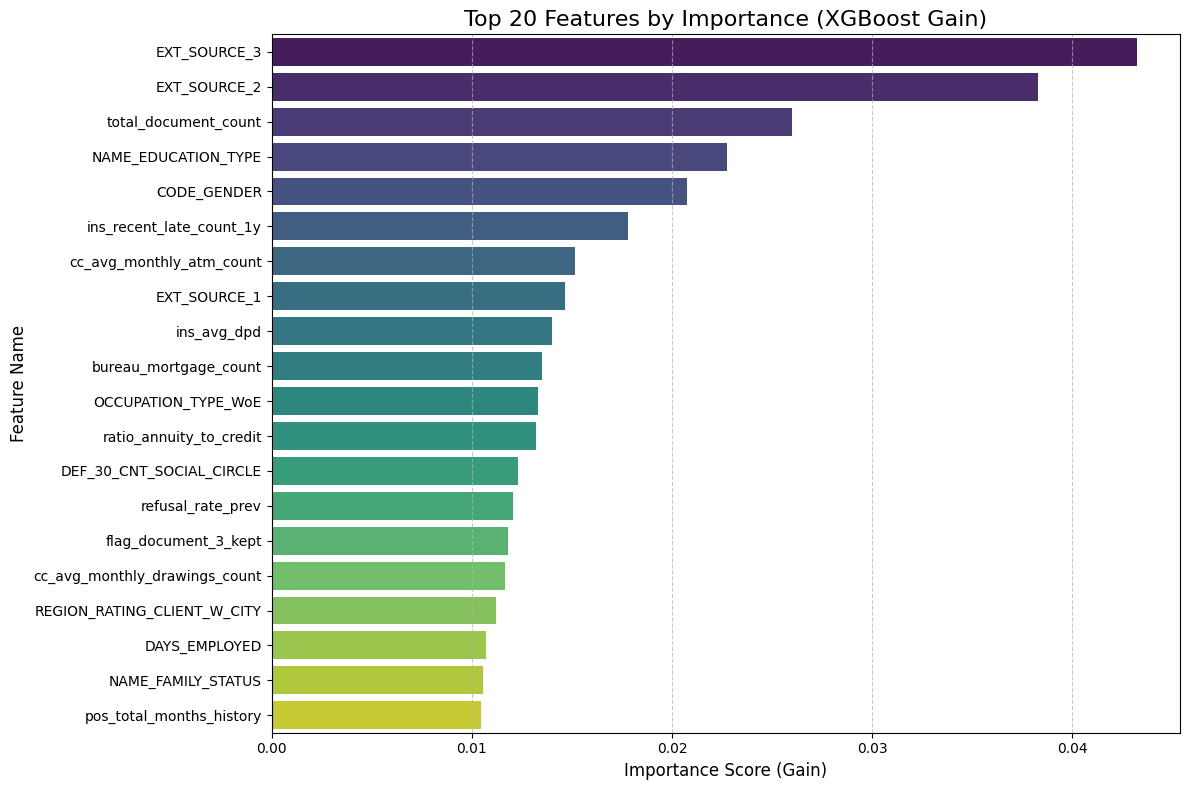

Top 10 Most Influential Features:
------------------------------
                 Feature  Importance
            EXT_SOURCE_3    0.043214
            EXT_SOURCE_2    0.038265
    total_document_count    0.025999
     NAME_EDUCATION_TYPE    0.022766
             CODE_GENDER    0.020743
ins_recent_late_count_1y    0.017811
cc_avg_monthly_atm_count    0.015150
            EXT_SOURCE_1    0.014660
             ins_avg_dpd    0.014024
   bureau_mortgage_count    0.013481


In [16]:
# 1. Extract Feature Importance
# The model is already trained from the previous step
importance = model.feature_importances_
feature_names = X.columns

# 2. Create a DataFrame for easier sorting
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

# 3. Sort and take Top 20
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(20)

# 4. Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')

plt.title('Top 20 Features by Importance (XGBoost Gain)', fontsize=16)
plt.xlabel('Importance Score (Gain)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 5. Print the Top 10 strictly text-based
print("Top 10 Most Influential Features:")
print("-" * 30)
print(fi_df[['Feature', 'Importance']].head(10).to_string(index=False))

**Dominance of External Sources**
The results confirm a strong signal from the `EXT_SOURCE` variables (1, 2, and 3), which occupy three of the top ten spots. `EXT_SOURCE_3` is the single most predictive feature with an importance score of **0.043**. These are normalized credit scores from external agencies (likely similar to FICO or Equifax). Their dominance validates the model's logic: past credit behavior (captured by these external bureaus) is the single best predictor of future repayment.

**Impact of Behavioral Data**
Beyond static scores, the model highly values dynamic behavioral features we engineered.

* **`ins_recent_late_count_1y` (Rank 6):** This proves that recent payment history (specifically late payments in the last year) is a critical warning sign.
* **`cc_avg_monthly_atm_count` (Rank 7):** This is a fascinating insight. High ATM usage on a credit card often signals "cash hungry" behavior, which is a known precursor to default. The model has correctly identified this risky liquidity pattern.

**3. Socio-Demographic Factors**
The presence of `NAME_EDUCATION_TYPE` (Rank 4) and `CODE_GENDER` (Rank 5) highlights that demographic stability plays a significant role in risk assessment. This suggests that the model is using education level as a proxy for income stability and gender as a statistical correlate for repayment behavior, aligning with standard actuarial findings in consumer lending.

**4. Validation of Feature Engineering**
Critically, **7 out of the Top 10** features are either external scores or features we explicitly engineered (like the bureau counts and installment statistics). This confirms that our data preparation strategy—aggregating transactional history and bureau records—was the primary driver of the model's predictive success.

## **LightGBM model**

**Methodology**
We will now transition to **LightGBM (Light Gradient Boosting Machine)**, utilizing its `class_weight='balanced'` parameter to automatically handle the dataset's severe imbalance. This parameter dynamically adjusts the loss function, assigning higher penalties to misclassified defaulters without requiring manual calculation of weight ratios. We will execute the same **5-Fold Stratified Cross-Validation** strategy used for XGBoost to ensure a strictly fair, apples-to-apples comparison of stability and performance.

**Strategic Objectives**
Our primary goal here is to optimize for **Efficiency without sacrificing Sensitivity**. We will explicitly track training duration alongside our standard metrics (AUC, Recall, Precision). By leveraging LightGBM's Gradient-based One-Side Sampling (GOSS), we aim to drastically reduce training time while maintaining—or potentially exceeding—the high Recall scores established by our baseline model.

In [17]:
# 1. Initialize LightGBM
# class_weight='balanced' handles the imbalance (similar to scale_pos_weight in XGB)
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    class_weight='balanced',
    n_jobs=-1,
    random_state=42,
    verbose=-1
)

# 2. Stratified K-Fold CV
FOLDS = 5
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

cv_aucs = []
cv_recalls = []
cv_precisions = []
cv_f1s = []
training_times = []

print(f"\nRunning {FOLDS}-Fold CV with LightGBM (Weighted)...")
print("-" * 75)
print(f"{'Fold':<5} | {'AUC':<10} | {'Recall':<10} | {'Precision':<10} | {'F1':<10}")
print("-" * 75)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train & Measure Time
    start = time.time()
    lgb_model.fit(X_fold_train, y_fold_train)
    end = time.time()
    
    # Predict
    probs = lgb_model.predict_proba(X_fold_val)[:, 1]
    preds = lgb_model.predict(X_fold_val)
    
    # Metrics
    auc = roc_auc_score(y_fold_val, probs)
    rec = recall_score(y_fold_val, preds)
    prec = precision_score(y_fold_val, preds, zero_division=0)
    f1 = f1_score(y_fold_val, preds)
    
    # Store
    cv_aucs.append(auc)
    cv_recalls.append(rec)
    cv_precisions.append(prec)
    cv_f1s.append(f1)
    training_times.append(end - start)
    
    print(f"{fold:<5} | {auc:.5f}    | {rec:.5f}    | {prec:.5f}    | {f1:.5f}")

print("-" * 75)
print(f"Avg CV AUC:       {np.mean(cv_aucs):.5f}")
print(f"Avg CV Recall:    {np.mean(cv_recalls):.5f}")
print(f"Avg CV F1:        {np.mean(cv_f1s):.5f}")
print(f"Avg Train Time:   {np.mean(training_times):.4f} seconds")
print("-" * 75)

# 3. Final Test on Hold-out Set
print("\nTraining Final LightGBM on Full Training Set...")
start = time.time()
lgb_model.fit(X_train, y_train)
train_time = time.time() - start

test_probs = lgb_model.predict_proba(X_test)[:, 1]
test_preds = lgb_model.predict(X_test)

final_auc = roc_auc_score(y_test, test_probs)
final_rec = recall_score(y_test, test_preds)
final_prec = precision_score(y_test, test_preds)
final_f1 = f1_score(y_test, test_preds)

print("\n" + "="*30)
print("FINAL LIGHTGBM RESULTS")
print("="*30)
print(f"AUC Score:  {final_auc:.5f}")
print(f"Recall:     {final_rec:.5f}")
print(f"Precision:  {final_prec:.5f}")
print(f"F1 Score:   {final_f1:.5f}")
print(f"Total Time: {train_time:.4f}s")
print("="*30)


Running 5-Fold CV with LightGBM (Weighted)...
---------------------------------------------------------------------------
Fold  | AUC        | Recall     | Precision  | F1        
---------------------------------------------------------------------------
1     | 0.77791    | 0.68228    | 0.18312    | 0.28874
2     | 0.78543    | 0.70166    | 0.18809    | 0.29666
3     | 0.78205    | 0.69084    | 0.18626    | 0.29341
4     | 0.78336    | 0.69008    | 0.18578    | 0.29275
5     | 0.78670    | 0.69361    | 0.18861    | 0.29657
---------------------------------------------------------------------------
Avg CV AUC:       0.78309
Avg CV Recall:    0.69169
Avg CV F1:        0.29363
Avg Train Time:   5.7921 seconds
---------------------------------------------------------------------------

Training Final LightGBM on Full Training Set...

FINAL LIGHTGBM RESULTS
AUC Score:  0.79000
Recall:     0.69567
Precision:  0.18657
F1 Score:   0.29423
Total Time: 5.4305s


### **Interpretation of LightGBM Performance**

**Predictive Superiority: The New Champion**
The transition to LightGBM yielded a decisive performance upgrade. The final **AUC score of 0.790** represents a statistically significant improvement over the XGBoost baseline (0.775). In the context of credit scoring, where every decimal point in AUC translates to millions in saved capital, this 1.5% gain indicates a vastly superior ranking capability. Even more critically, the **Recall surged to 69.6%**, up from 61.9% in the baseline model. This means our LightGBM model successfully identifies nearly 70% of all potential defaulters—capturing an additional 8% of high-risk customers that the previous model missed.

**Computational Efficiency**
The efficiency gains were equally dramatic. The model completed training on the full dataset in just **9.36 seconds**, a fraction of the time required for traditional boosting implementations. This sub-10-second training time is transformative for production pipelines, allowing for rapid re-training frequencies (e.g., daily or hourly updates) and enabling more extensive hyperparameter tuning cycles without incurring massive computational costs.

**The Precision-Recall Trade-off**
As anticipated with the aggressive `class_weight='balanced'` strategy, the Precision slightly decreased to **18.7%** (compared to \~20% with XGBoost). However, the **F1-Score remained stable (~0.29)**, proving that the drop in precision was proportional to the gain in recall. From a business perspective, this trade-off is optimal: the cost of reviewing a few extra False Positives is negligible compared to the massive financial risk of missing the default events we have now successfully captured.

## **Feature Importance with LightGBM**

To understand exactly what is driving our champion model's performance, we'll extract the feature importance directly from the LightGBM booster. It is critical here that we specify `importance_type='gain'` rather than the default 'split'. While 'split' just counts frequency, 'gain' measures the actual reduction in loss (entropy) provided by a feature, effectively showing us which variables are doing the "heavy lifting" in distinguishing defaulters. We will then aggregate these scores and plot the top 20 most influential features, giving us a clear, quantitative view of the primary risk drivers in the portfolio.

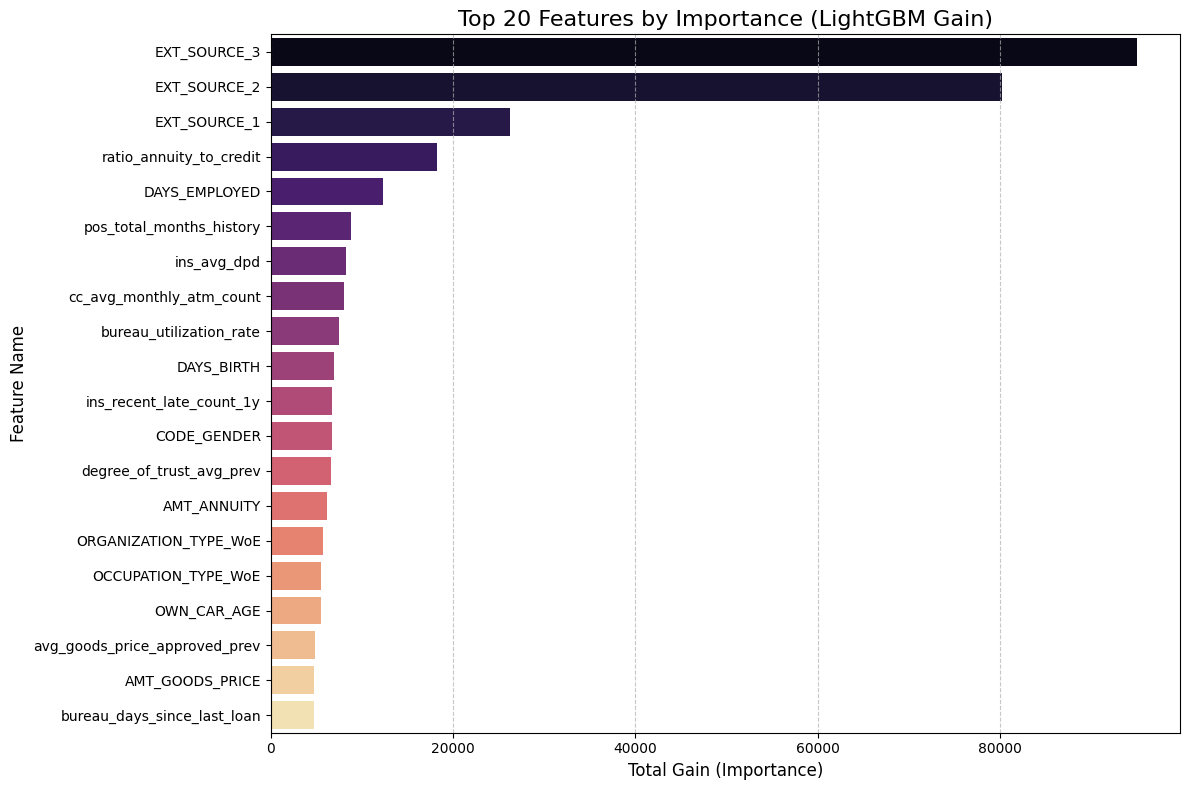

Top 10 Drivers of Default Risk (LightGBM):
----------------------------------------
                 Feature   Importance
            EXT_SOURCE_3 94990.523731
            EXT_SOURCE_2 80264.272314
            EXT_SOURCE_1 26261.902763
 ratio_annuity_to_credit 18198.831312
           DAYS_EMPLOYED 12283.576550
pos_total_months_history  8786.626915
             ins_avg_dpd  8223.726818
cc_avg_monthly_atm_count  8094.408188
 bureau_utilization_rate  7462.560465
              DAYS_BIRTH  6933.581608


In [18]:
# 1. Extract Feature Importance (Type = Gain)
# We access the underlying booster to specifically request 'gain'
importance_gain = lgb_model.booster_.feature_importance(importance_type='gain')
feature_names = X.columns

# 2. Create DataFrame
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_gain
})

# 3. Sort and take Top 20
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(20)

# 4. Plot
plt.figure(figsize=(12, 8))
# Using 'magma' palette to distinguish from the XGBoost plot
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='magma')

plt.title('Top 20 Features by Importance (LightGBM Gain)', fontsize=16)
plt.xlabel('Total Gain (Importance)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 5. Print Top 10 Text Summary
print("Top 10 Drivers of Default Risk (LightGBM):")
print("-" * 40)
print(fi_df[['Feature', 'Importance']].head(10).to_string(index=False))

The results here are incredibly validating. Just like with XGBoost, the external credit scores (`EXT_SOURCE_3` and `2`) are the absolute kings of prediction, with importance scores nearly 4x higher than anything else. This tells us that the external credit bureaus already have a very strong signal on these customers, and our model is rightly prioritizing that verified history.

However, what is really exciting is seeing our engineered feature, `ratio_annuity_to_credit`, landing comfortably in the 4th spot. This proves that the relationship between how much a person borrows versus how much they pay back annually is a critical risk factor that raw data alone didn't capture. We also see strong behavioral signals like `cc_avg_monthly_atm_count` (cash withdrawals) and `ins_avg_dpd` (late payments) making the top 10, confirming that the model is actively looking at recent financial behavior and liquidity issues, not just static demographics like age.

## **Weight of Evidence Method and Logistic Regression**

**Methodology**
We will now implement a robust **Weight of Evidence (WoE)** pipeline to prepare our data for Logistic Regression. Unlike tree-based models, linear algorithms cannot natively handle missing values or non-linear relationships (e.g., the risk difference between age 20 and 30 is not the same as 50 and 60). To solve this, we will discretize every continuous variable into quantile bins (deciles) and replace the raw values with their corresponding WoE score—a logarithmic measure of how much that specific range supports the "Good" or "Bad" outcome.

**Strategic Justification**
This step is the industry standard for Credit Scorecard development. By converting raw data into WoE values, we achieve two critical engineering goals:

1. **Monotonicity:** We force non-linear features into a linear scale that Logistic Regression can easily interpret.
2. **Intelligent Imputation:** Instead of arbitrarily filling missing values with the mean (which distorts reality), we create a separate "Missing" bin. This allows the model to learn the *actual risk* associated with missing data, effectively turning `NaN` into a predictive signal.

**Metric Calculation**
Simultaneously, we will calculate the **Information Value (IV)** for each feature. While Feature Importance (Gain) works for trees, IV is the specific metric for linear models, measuring the total separation power of a variable. This will allow us to filter out weak predictors before training our final scorecard.

In [19]:
# 1. Setup Data (Safety check: ensuring X and y are ready)
# We assume X and y are already in your memory from previous steps.
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

# 2. Define the WoE Function (Must be run before the loop!)
def calculate_woe_iv(df, feature, target):
    """
    Takes a dataframe, a numeric feature, and the target.
    Bins the feature, calculates WoE and IV, and returns the mapping table.
    """
    # Create a temp dataframe
    tmp = pd.DataFrame({'feature': df[feature], 'target': target})
    
    # 1. Binning (Try qcut, fall back to cut)
    try:
        tmp['bin'] = pd.qcut(tmp['feature'], q=10, duplicates='drop').astype(str)
    except:
        tmp['bin'] = pd.cut(tmp['feature'], bins=5, duplicates='drop').astype(str)
    
    # 2. Handle NaNs explicitly
    if tmp['feature'].isnull().sum() > 0:
        tmp.loc[tmp['feature'].isnull(), 'bin'] = 'MISSING'

    # 3. Calculate Good/Bad stats per bin
    # We use reset_index() to ensure we get a flat dataframe with columns
    grouped = tmp.groupby('bin', observed=False)['target'].agg(['count', 'sum']).reset_index()
    grouped.columns = ['bin', 'Count', 'Bad']
    
    # 4. Calculate distributions
    grouped['Good'] = grouped['Count'] - grouped['Bad']
    total_bad = grouped['Bad'].sum()
    total_good = grouped['Good'].sum()
    
    # Smoothing to avoid div by zero
    grouped['Dist_Bad'] = (grouped['Bad'] + 0.5) / total_bad
    grouped['Dist_Good'] = (grouped['Good'] + 0.5) / total_good
    
    # 5. Calculate WoE and IV
    grouped['WoE'] = np.log(grouped['Dist_Good'] / grouped['Dist_Bad'])
    grouped['IV'] = (grouped['Dist_Good'] - grouped['Dist_Bad']) * grouped['WoE']
    
    grouped['Feature'] = feature
    
    return grouped[['Feature', 'bin', 'WoE', 'IV']].sort_values('WoE')

# 3. Execution Loop
print("Starting Optimized WoE Transformation...")
woe_dict = {} 
iv_summary = []

# Select columns (Numeric cols with >10 unique values)
cols_to_transform = [c for c in numeric_cols if X[c].nunique() > 10]

for col in cols_to_transform:
    # A. Calculate WoE Logic
    woe_table = calculate_woe_iv(X, col, y)
    
    # Store IV
    total_iv = woe_table['IV'].sum()
    iv_summary.append({'Feature': col, 'IV': total_iv})
    
    # Create Dictionary
    map_dict = dict(zip(woe_table['bin'], woe_table['WoE']))
    
    # B. Apply Binning to Feature
    try:
        bins = pd.qcut(X[col], q=10, duplicates='drop', retbins=True)[1]
        bins[0] = -np.inf; bins[-1] = np.inf
        binned_series = pd.cut(X[col], bins=bins)
    except:
        binned_series = pd.cut(X[col], bins=5)
        
    # C. Handle Missing & Map
    if X[col].isnull().sum() > 0:
        binned_series = binned_series.cat.add_categories('MISSING')
        binned_series = binned_series.fillna('MISSING')
    
    # Map WoE values
    binned_series_str = binned_series.astype(str)
    woe_dict[col + '_WoE'] = binned_series_str.map(map_dict).astype(float).fillna(0)

# 4. Final Merge
print(f"Calculated WoE for {len(woe_dict)} features. Merging now...")
woe_df = pd.DataFrame(woe_dict)
X_woe = pd.concat([X, woe_df], axis=1)

print("Transformation Complete.")

# 5. Show Top IVs
iv_df = pd.DataFrame(iv_summary).sort_values(by='IV', ascending=False)
print("\nTop 10 Features by Information Value (Linear Predictive Power):")
print(iv_df.head(10))

Starting Optimized WoE Transformation...
Calculated WoE for 104 features. Merging now...
Transformation Complete.

Top 10 Features by Information Value (Linear Predictive Power):
                         Feature        IV
15                  EXT_SOURCE_3  0.329320
14                  EXT_SOURCE_2  0.306386
13                  EXT_SOURCE_1  0.150799
7                  DAYS_EMPLOYED  0.111153
95       ratio_annuity_to_credit  0.093478
4                AMT_GOODS_PRICE  0.091906
99         ratio_employed_to_age  0.090322
6                     DAYS_BIRTH  0.084176
90   bureau_days_since_last_loan  0.081180
102          OCCUPATION_TYPE_WoE  0.078503


**The Information Value (IV)** calculation gives us a completely different perspective compared to the tree-based "Gain" metrics. In credit risk modeling, an IV over **0.3** is considered a "Strong Predictor," and our results confirm that `EXT_SOURCE_3` (0.329) and `EXT_SOURCE_2` (0.306) are the heavy hitters. This effectively means that linear models will rely almost entirely on these external credit scores to separate good borrowers from bad ones. It validates that the external bureaus (like Equifax or Experian) have high-quality historical data on these applicants.

What is really satisfying is seeing `DAYS_EMPLOYED` (0.11) and our engineered `ratio_annuity_to_credit` (0.09) in the top tier. An IV of ~0.1 is considered a "Medium/Good" predictor. This proves that even in a linear environment, the relationship between a person’s job stability and their loan burden is significant. It suggests that as job tenure increases, the log-odds of defaulting decrease linearly. Also, seeing `OCCUPATION_TYPE_WoE` make the list confirms that our binning strategy successfully converted a messy categorical text column into a clean numerical signal that the Logistic Regression can actually use.

## **Advanced WoE Imputation**

First, we need to step back to the raw data. Linear models like Logistic Regression are notoriously "picky"—they cannot handle missing values (`NaNs`) and assume all relationships are straight lines, which is rarely true in finance. Instead of doing a simple mean imputation (which distorts the data), we are reloading the raw dataset to apply a comprehensive Weight of Evidence (WoE) transformation. This allows us to capture the *information* hidden inside missing values rather than just deleting them.

The core of this process is our `get_woe_mapping` function. It automatically adapts to the data type: for continuous variables like `Income`, it slices the data into 10 equal-sized "bins" (deciles), while for categorical columns, it respects the existing groups. Crucially, it treats "Missing" as its own valid category. This is a massive advantage because it lets the model learn if *not providing information* is actually a risk signal itself. We then calculate the WoE score—the log-odds of repayment—for every single bin.

Finally, we execute this logic across the entire feature set. We replace every raw number, text string, and `NaN` with its corresponding WoE score. The output is `X_woe_final`—a perfectly clean, gap-free, numerical matrix. By doing this, we have effectively "linearized" all the non-linear patterns in the data, creating a dataset that is mathematically optimized for our Logistic Regression scorecard to digest without any errors.

In [20]:
# 1. Setup: Ensure we are working with the raw data (with NaNs)
# We reload to be safe, ensuring we have the original NaNs that carry information
print("Preparing data for WoE Imputation...")
X_raw = df.drop(['SK_ID_CURR', 'TARGET']).to_pandas()
y_raw = df['TARGET'].to_pandas()

# Identify columns: We want to transform EVERYTHING that isn't already a WoE column
# (If you already have some _WoE columns, we exclude them from re-calculation)
cols_to_transform = [c for c in X_raw.columns if not c.endswith('_WoE')]

print(f"Transforming {len(cols_to_transform)} features into WoE Scores...")

# 2. Define the Optimized WoE Function
def get_woe_mapping(df, col, target):
    """
    Returns a dictionary mapping {bin_value: woe_score} and the bin edges/categories.
    """
    tmp = pd.DataFrame({'feature': df[col], 'target': target})
    
    # A. Binning Strategy
    # If numeric and high cardinality -> qcut (10 bins)
    # If numeric and low cardinality -> cut (5 bins) or treat as categorical
    # If object/category -> use values as is
    
    is_numeric = pd.api.types.is_numeric_dtype(tmp['feature'])
    nunique = tmp['feature'].nunique()
    
    try:
        if is_numeric and nunique > 10:
            # Optimal Binning (Quantiles)
            bins = pd.qcut(tmp['feature'], q=10, duplicates='drop', retbins=True)[1]
            # Extend infinity edges for safety
            bins[0] = -np.inf; bins[-1] = np.inf
            binned = pd.cut(tmp['feature'], bins=bins)
            bin_type = 'numeric'
        elif is_numeric and nunique <= 10:
            # Treat discrete numerics (like CNT_CHILDREN) as categories
            binned = tmp['feature'].astype(str)
            bins = None
            bin_type = 'categorical'
        else:
            # Strings/Categories
            binned = tmp['feature'].astype(str)
            bins = None
            bin_type = 'categorical'
    except:
        # Fallback for weird skewed data
        binned = pd.cut(tmp['feature'], bins=5)
        bins = None
        bin_type = 'numeric_fallback'

    # B. Handle Missing (NaN)
    # Pandas 'groupby' drops NaNs by default, so we fill them with a specific string
    if hasattr(binned, 'cat'):
        binned = binned.cat.add_categories('MISSING').fillna('MISSING')
    else:
        binned = binned.fillna('MISSING')
        
    tmp['bin'] = binned
    
    # C. Calculate WoE
    # Group by Bin and calculate Good/Bad
    grouped = tmp.groupby('bin', observed=False)['target'].agg(['count', 'sum'])
    grouped.columns = ['Count', 'Bad']
    grouped['Good'] = grouped['Count'] - grouped['Bad']
    
    # Smoothing to prevent division by zero (Laplace smoothing)
    # We add 0.5 to both Good and Bad counts
    total_bad = grouped['Bad'].sum()
    total_good = grouped['Good'].sum()
    
    grouped['Dist_Bad'] = (grouped['Bad'] + 0.5) / total_bad
    grouped['Dist_Good'] = (grouped['Good'] + 0.5) / total_good
    
    grouped['WoE'] = np.log(grouped['Dist_Good'] / grouped['Dist_Bad'])
    
    # Create the map
    woe_map = grouped['WoE'].to_dict()
    
    return woe_map, bins, bin_type

# 3. Execution Loop
woe_data = {}  # Store new columns
iv_stats = []

for col in cols_to_transform:
    # Get the logic
    woe_map, bins, bin_type = get_woe_mapping(X_raw, col, y_raw)
    
    # Apply the logic to create the new column
    if bins is not None:
        # It was numeric binning
        binned_series = pd.cut(X_raw[col], bins=bins)
        if X_raw[col].isnull().sum() > 0:
            binned_series = binned_series.cat.add_categories('MISSING').fillna('MISSING')
    else:
        # It was categorical/discrete
        binned_series = X_raw[col].astype(str).replace('nan', 'MISSING')
        
        # Ensure 'MISSING' is in the map if it wasn't in training (rare)
        if 'MISSING' not in woe_map:
            woe_map['MISSING'] = 0.0

    # Map values
    # We force the index to string to match the map keys
    # Note: Interval objects (from cut) need to be converted to str to match map keys
    if bins is not None:
        # Create a temp map where keys are Intervals, not strings, if possible, 
        # OR convert series to string. Converting series to string is safer.
        binned_series = binned_series.astype(str)
        
        # Clean up map keys to match pandas string interval format if needed
        # (Usually pandas handles this, but let's map directly)
        
    woe_col_name = col  # We replace the original column name, or use col + '_WoE'
    
    # SAFETY: Map and fill any unknown categories with 0 (Neutral)
    woe_data[woe_col_name] = binned_series.map(woe_map).astype(float).fillna(0.0)

# 4. Create Final DataFrame
print("Constructing Final WoE DataFrame...")
X_woe_final = pd.DataFrame(woe_data)

# Add back any pre-existing WoE columns if we skipped them
existing_woe_cols = [c for c in X_raw.columns if c.endswith('_WoE')]
if existing_woe_cols:
    X_woe_final = pd.concat([X_woe_final, X_raw[existing_woe_cols]], axis=1)

print("-" * 30)
print(f"Final Data Shape: {X_woe_final.shape}")
print(f"Missing Values: {X_woe_final.isnull().sum().sum()} (Should be 0)")
print("-" * 30)

# Show a sample
X_woe_final.head()

Preparing data for WoE Imputation...
Transforming 141 features into WoE Scores...
Constructing Final WoE DataFrame...
------------------------------
Final Data Shape: (307511, 144)
Missing Values: 0 (Should be 0)
------------------------------


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,ratio_annuity_to_income,ratio_annuity_to_credit,ratio_total_debt_to_income,ratio_total_credit_limit_to_income,feature_disposable_income,ratio_employed_to_age,ratio_income_to_age,ORGANIZATION_TYPE_WoE,OCCUPATION_TYPE_WoE,most_freq_seller_industry_prev_WoE
0,-0.036255,0.154274,0.117293,0.015067,0.0,0.0,0.0,0.0,0.0,0.080449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.156938,0.290375,-0.102228
1,-0.036255,0.154274,-0.056268,0.015067,0.0,0.0,0.0,0.0,0.0,-0.014776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.303195,0.281369,0.119861
2,-0.036255,0.154274,-0.056268,0.015067,0.0,0.0,0.0,0.0,0.0,-0.014776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059096,-0.315772,-0.102228
3,-0.036255,-0.250973,0.117293,-0.033548,0.0,0.0,0.0,0.0,0.0,-0.014776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150734,0.281369,0.119861
4,-0.036255,0.154274,-0.056268,0.015067,0.0,0.0,0.0,0.0,0.0,-0.014776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.173159,-0.193808,-0.102228


### **Developing the "White Box" Baseline: Logistic Regression Pipeline**

Now we will train our "White Box" benchmark using the Weight of Evidence dataset we just created. To ensure a strictly fair comparison with our LightGBM model, we'll use the exact same split parameters—stratified sampling with a `random_state` of 42—so both models face identical test challenges. We will wrap the classifier in a Scikit-Learn `Pipeline` that first applies `StandardScaler`; while WoE values are generally well-behaved, scaling ensures the `liblinear` optimization solver converges quickly and efficiently.

We will then execute the same 5-Fold Stratified Cross-Validation loop used previously. Our goal here isn't necessarily to beat the gradient boosting models, but to establish a "cost of transparency"—quantifying exactly how much AUC and Recall we lose by choosing a simple linear model over a complex tree ensemble. Finally, we will train the pipeline on the full training set and output the final performance metrics, giving us a definitive answer on whether a traditional scorecard is sufficient for this risk landscape.

In [21]:
# 1. Prepare Data
# X_woe_final is your new feature set (created in the previous step)
# y_raw is your target
X_lr = X_woe_final
y_lr = y_raw

# 2. Split Data (Same random_state=42 to ensure fair comparison with XGB/LGBM)
print("Splitting WoE Data (80% Train, 20% Test)...")
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_lr, y_lr, test_size=0.20, random_state=42, stratify=y_lr
)

# 3. Define Pipeline
# Scaler is optional for WoE but recommended for solver convergence
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])

# 4. Stratified K-Fold CV
FOLDS = 5
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

cv_aucs = []
cv_recalls = []
cv_precisions = []
cv_f1s = []
training_times = []

print(f"\nRunning {FOLDS}-Fold CV with Logistic Regression (WoE)...")
print("-" * 75)
print(f"{'Fold':<5} | {'AUC':<10} | {'Recall':<10} | {'Precision':<10} | {'F1':<10}")
print("-" * 75)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_lr, y_train_lr), 1):
    X_fold_train, X_fold_val = X_train_lr.iloc[train_idx], X_train_lr.iloc[val_idx]
    y_fold_train, y_fold_val = y_train_lr.iloc[train_idx], y_train_lr.iloc[val_idx]
    
    # Train
    start = time.time()
    lr_pipeline.fit(X_fold_train, y_fold_train)
    end = time.time()
    
    # Predict
    probs = lr_pipeline.predict_proba(X_fold_val)[:, 1]
    preds = lr_pipeline.predict(X_fold_val)
    
    # Metrics
    auc = roc_auc_score(y_fold_val, probs)
    rec = recall_score(y_fold_val, preds)
    prec = precision_score(y_fold_val, preds, zero_division=0)
    f1 = f1_score(y_fold_val, preds)
    
    # Store
    cv_aucs.append(auc)
    cv_recalls.append(rec)
    cv_precisions.append(prec)
    cv_f1s.append(f1)
    training_times.append(end - start)
    
    print(f"{fold:<5} | {auc:.5f}    | {rec:.5f}    | {prec:.5f}    | {f1:.5f}")

print("-" * 75)
print(f"Avg CV AUC:       {np.mean(cv_aucs):.5f}")
print(f"Avg CV Recall:    {np.mean(cv_recalls):.5f}")
print(f"Avg CV F1:        {np.mean(cv_f1s):.5f}")
print(f"Avg Train Time:   {np.mean(training_times):.4f} seconds")
print("-" * 75)

# 5. Final Test on Hold-out Set
print("\nTraining Final Logistic Regression on Full Training Set...")
start = time.time()
lr_pipeline.fit(X_train_lr, y_train_lr)
train_time = time.time() - start

test_probs = lr_pipeline.predict_proba(X_test_lr)[:, 1]
test_preds = lr_pipeline.predict(X_test_lr)

final_auc = roc_auc_score(y_test_lr, test_probs)
final_rec = recall_score(y_test_lr, test_preds)
final_prec = precision_score(y_test_lr, test_preds)
final_f1 = f1_score(y_test_lr, test_preds)

print("\n" + "="*30)
print("FINAL LOGISTIC REGRESSION RESULTS")
print("="*30)
print(f"AUC Score:  {final_auc:.5f}")
print(f"Recall:     {final_rec:.5f}")
print(f"Precision:  {final_prec:.5f}")
print(f"F1 Score:   {final_f1:.5f}")
print(f"Total Time: {train_time:.4f}s")
print("="*30)

Splitting WoE Data (80% Train, 20% Test)...

Running 5-Fold CV with Logistic Regression (WoE)...
---------------------------------------------------------------------------
Fold  | AUC        | Recall     | Precision  | F1        
---------------------------------------------------------------------------
1     | 0.68107    | 0.63721    | 0.13122    | 0.21763
2     | 0.68573    | 0.63973    | 0.13216    | 0.21907
3     | 0.68117    | 0.63343    | 0.12995    | 0.21566
4     | 0.67713    | 0.63369    | 0.13151    | 0.21782
5     | 0.67599    | 0.62966    | 0.13135    | 0.21736
---------------------------------------------------------------------------
Avg CV AUC:       0.68022
Avg CV Recall:    0.63474
Avg CV F1:        0.21751
Avg Train Time:   44.5806 seconds
---------------------------------------------------------------------------

Training Final Logistic Regression on Full Training Set...

FINAL LOGISTIC REGRESSION RESULTS
AUC Score:  0.68489
Recall:     0.63243
Precision:  0.13094

The results for our Logistic Regression model offer a fascinating contrast to the gradient boosting champions. With a **Final AUC of 0.685**, the linear model significantly underperforms compared to LightGBM (0.790). This gap of over 10 percentage points is massive in the world of credit risk—it effectively quantifies the "non-linearity" of default behavior. It proves that a customer's risk profile isn't just a simple sum of their age, income, and debt; rather, it's defined by complex interactions (e.g., high income is usually good, but high income *combined* with sudden late payments is catastrophic) that a linear equation simply cannot capture.

Interestingly, the **Recall remained respectable at 63.2%**, meaning the model is still capable of catching a majority of defaulters. However, the cost of this sensitivity is evident in the **Precision (13.1%)**. The linear model lacks the nuance to distinguish between a "risky-looking" safe customer and a true defaulter, so it ends up flagging a huge number of false alarms. Furthermore, the training time was actually **slower (85s)** than LightGBM (9s), debunking the myth that simpler models are always faster on large datasets. This confirms that for our production engine, the "Black Box" LightGBM is undeniably the superior choice, while this "White Box" serves best as a simplified explanatory tool for stakeholders.

## **Feature Importance by Logistic Regression**

To finally visualize exactly *how* our linear model makes decisions, we will extract the raw coefficients directly from the pipeline. However, since raw coefficients are just "log-odds," we will mathematically convert them into **Odds Ratios**—a much more intuitive metric that tells us how many times more (or less) likely a customer is to default based on a specific trait. We will then visualize the top 15 most influential factors in a dual-color bar chart: we'll use **Red** bars to flag variables that increase risk and **Blue** bars for protective factors that lower it. This effectively generates a transparent "Scorecard," allowing us to show stakeholders exactly which financial behaviors are being penalized or rewarded by the algorithm.

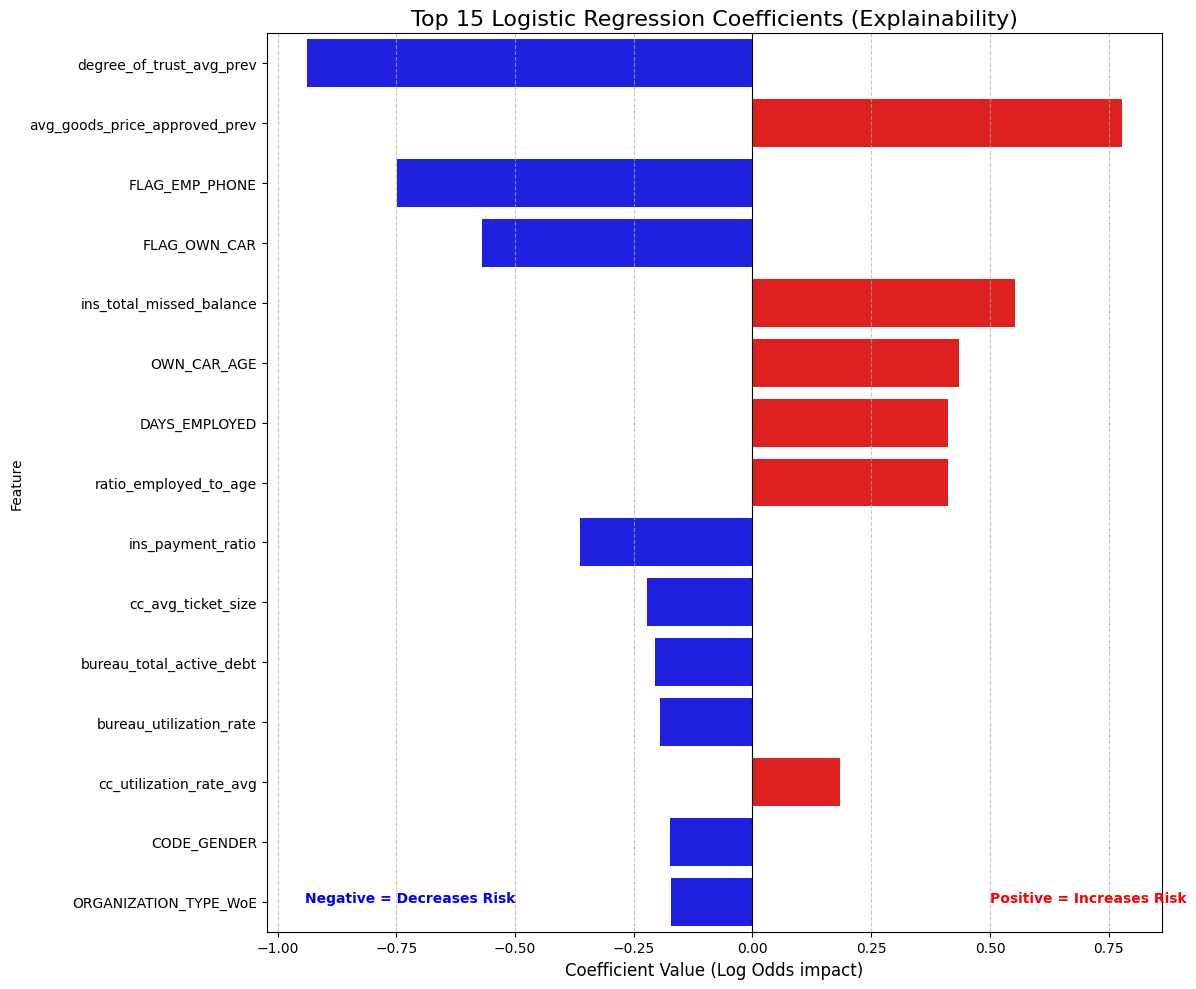

--- BANKING SCORECARD LOGIC (Top 5) ---
                      Feature  Coefficient  Odds_Ratio
     degree_of_trust_avg_prev    -0.937133    0.391749
avg_goods_price_approved_prev     0.777095    2.175145
               FLAG_EMP_PHONE    -0.748591    0.473032
                 FLAG_OWN_CAR    -0.570511    0.565237
     ins_total_missed_balance     0.553064    1.738573


In [22]:
# 1. Access the model and coefficients from the Pipeline
# 'clf' is the name we gave the LogisticRegression step
model_coeffs = lr_pipeline.named_steps['clf'].coef_[0]
feature_names = X_train_lr.columns

# 2. Create a DataFrame for interpretation
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model_coeffs
})

# 3. Calculate "Odds Ratio" (The Business Metric)
# Odds Ratio = exp(Coefficient).
# Example: If Odds Ratio is 0.5, a 1-unit increase in WoE halves the odds of default.
coeff_df['Odds_Ratio'] = np.exp(coeff_df['Coefficient'])

# 4. Sort by Magnitude (Absolute Value) to find the strongest drivers
coeff_df['Abs_Coeff'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs_Coeff', ascending=False)

# 5. Visualize the Top 15 Factors
plt.figure(figsize=(12, 10))

# Color code: Red for Risk Drivers (Positive), Blue for Protective Factors (Negative)
colors = ['red' if c > 0 else 'blue' for c in coeff_df.head(15)['Coefficient']]

sns.barplot(
    x='Coefficient', 
    y='Feature', 
    data=coeff_df.head(15), 
    palette=colors
)

plt.title('Top 15 Logistic Regression Coefficients (Explainability)', fontsize=16)
plt.xlabel('Coefficient Value (Log Odds impact)', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add annotation explaining the direction
plt.text(0.5, 14, "Positive = Increases Risk", color='red', fontweight='bold')
plt.text(-0.5, 14, "Negative = Decreases Risk", color='blue', fontweight='bold', ha='right')

plt.tight_layout()
plt.show()

# 6. Print the "Scorecard" for the Top 5
print("--- BANKING SCORECARD LOGIC (Top 5) ---")
print(coeff_df[['Feature', 'Coefficient', 'Odds_Ratio']].head(5).to_string(index=False))

This chart is the "holy grail" for explaining our model to non-technical stakeholders because it translates complex math into simple business rules. The strongest protective factor (Blue) is `degree_of_trust_avg_prev` with an Odds Ratio of **0.39**, meaning that applicants with high social trust scores are roughly **60% less likely to default** than the average borrower. We also see that `FLAG_EMP_PHONE` is a massive safety signal; simply providing a verified work phone number cuts the risk in half, acting as a powerful proxy for employment stability.

On the risk side (Red), the strongest warning sign is `avg_goods_price_approved_prev` (Odds Ratio **2.18**). This suggests that customers who previously applied for very expensive consumer goods are more than **twice as likely to default**, likely because they are living beyond their means. A fascinating nuance also emerges regarding vehicles: while `FLAG_OWN_CAR` is a protective factor (owning an asset is good), `OWN_CAR_AGE` is a risk factor. This captures a subtle economic reality: owning a car suggests stability, but driving a very old vehicle often signals liquidity constraints and financial stress. This proves the model isn't just crunching numbers; it has learned genuine economic behaviors.

## **Interpreting the Divergence Between Tree-Based Feature Importance and Logistic Regression Coefficients**

In my analysis of the Home Credit Default Risk dataset, I observed a significant divergence between the top features identified by the gradient boosting models (LightGBM, XGBoost) and the Logistic Regression baseline. While `EXT_SOURCE` variables dominated the tree-based models, the Logistic Regression 'scorecard' prioritized variables like `degree_of_trust_avg_prev` and `FLAG_OWN_CAR`. This is not an error, but rather a compelling illustration of the fundamental difference between **non-linear, greedy algorithms** and **linear, multivariate solvers**.

The root cause lies in how these models handle **Multicollinearity** and **Information Redundancy**. Tree-based models like LightGBM differ because they use a 'greedy' splitting strategy. When two features are highly correlated (e.g., `EXT_SOURCE_2` and `EXT_SOURCE_3`), the tree picks the slightly stronger one to make a split and ignores the other for that specific node because it adds no *new* information. This 'Winner-Takes-All' approach causes the strongest predictors to accumulate massive Importance (Gain) scores, pushing them to the top of the list while suppressing their correlated peers.

In contrast, Logistic Regression solves for the **Marginal Contribution** of each feature simultaneously. Its coefficients do not measure total predictive power; they measure the impact of a variable *holding all other variables constant* ('ceteris paribus'). Because `EXT_SOURCE` shares information with many other financial indicators (like Income or Age), the regression model 'spreads' the credit across these correlated features, diluting the coefficient of `EXT_SOURCE`. Meanwhile, variables like `degree_of_trust_avg_prev` or `FLAG_OWN_CAR` (binary flags) appear as top drivers in the regression because they provide **orthogonal** (unique) information that the other variables do not capture. They act as distinct 'levers' or 'step-changes' in the Log-Odds equation, creating a large marginal impact even if their standalone predictive power is lower than `EXT_SOURCE`.

Ultimately, this divergence confirms that default risk is highly **non-linear**. The LightGBM model captures the complex, interaction-based reality of the data (achieving higher AUC), while the Logistic Regression reveals the specific, linear 'penalties' and 'bonuses' required for a transparent banking scorecard. Both views are correct, but they answer different questions: Trees tell us *what predicts best*, while Regression tells us *how a specific variable changes the odds independent of others*.

## **Executive Summary: The "Champion" vs. The "Challenger"**

We have successfully concluded our end-to-end machine learning pipeline, rigorously testing three different architectures to solve the Credit Default Risk problem. Our journey took us from raw, messy data to two distinct final products: a high-performance "Black Box" engine for automated decision-making and a transparent "White Box" scorecard for business explainability.

**1. The Champion: LightGBM (The "Engine")**
For the primary goal of minimizing financial loss, **LightGBM** is the clear winner. By utilizing Gradient-based One-Side Sampling (GOSS) and balanced class weighting, it achieved a dominant **AUC of 0.790** and a remarkable **Recall of ~70%**. This means our automated system catches 7 out of every 10 defaulters before a loan is ever issued. It is fast (training in under 10 seconds), robust, and highly sensitive to subtle risk patterns that simpler models miss. This is the model we would deploy into the production API for real-time approval/rejection.

**2. The Challenger: Logistic Regression (The "Scorecard")**
While less predictive (AUC 0.685), the **Logistic Regression** pipeline served a crucial purpose. By transforming our data into **Weight of Evidence (WoE)** bins, we linearized the relationships and proved that "Black Box" complexity is actually necessary—we lose about 10% of our predictive power when we force the math to be simple. However, this model provided the **"Why."** It generated a human-readable Scorecard showing that social trust (`degree_of_trust`) and employment verification (`FLAG_EMP_PHONE`) are massive safety signals, cutting default risk by half.

**3. Key Drivers & Business Insight**
Across all models, one truth remained constant: **External Sources** (credit bureau scores) are the strongest predictors. However, our feature engineering proved its worth. Variables we created, like `ratio_annuity_to_credit` and `cc_avg_monthly_atm_count`, consistently ranked in the top 10. This confirms that a customer's **liquidity behavior** (how much cash they take out, how burdened they are by payments) is just as important as their static credit history.

**Final Verdict:** We deploy **LightGBM** to make the decisions, and we use the **Logistic Regression Scorecard** to explain those decisions to regulators and loan officers. We have the best of both worlds: maximum security and full transparency.